In [1]:
import tensorflow as tf

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0' # Set to -1 if CPU should be used CPU = -1 , GPU = 0

gpus = tf.config.experimental.list_physical_devices('GPU')
cpus = tf.config.experimental.list_physical_devices('CPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
elif cpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        logical_cpus= tf.config.experimental.list_logical_devices('CPU')
        print(len(cpus), "Physical CPU,", len(logical_cpus), "Logical CPU")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
# import the necessary packages
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np

# grab the MNIST dataset (if this is your first time using this
# dataset then the 11MB download may take a minute)
print("[INFO] accessing MNIST...")
((x_train, y_train), (x_test, y_test)) = mnist.load_data()
x_test = x_test / 255
x_train = x_train / 255
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

[INFO] accessing MNIST...
11493376/11490434 [==============================] - 0s 0us/step


In [4]:
print(len(x_train))
print(len(x_test))

60000
10000


In [5]:
# convert the labels from integers to vectors
le = LabelBinarizer()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [6]:
# initialize the optimizer and model
print("[INFO] compiling model...")
opt = Adam(lr=0.001)

width=28
height=28
depth=1
classes=10

[INFO] compiling model...


In [7]:
print(K.image_data_format())

channels_last


In [8]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

# initialize the model
model = Sequential()
inputShape = (height, width, depth)

# if we are using "channels first", update the input shape
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)

# first set of CONV => RELU => POOL layers
model.add(Conv2D(20, (5, 5), padding="same", input_shape=inputShape))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# second set of CONV => RELU => POOL layers
model.add(Conv2D(50, (5, 5), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# first (and only) set of FC => RELU layers
model.add(Flatten())
model.add(Dense(500))
model.add(Activation("relu"))

# softmax classifier
model.add(Dense(classes))
model.add(Activation("softmax"))

model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 20)        520       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 20)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 50)        25050     
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 50)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 50)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2450)              0

In [10]:
# train the network
print("[INFO] training network...")
H = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=128, epochs=20, verbose=1)

[INFO] training network...
Epoch 1/20
469/469 [==============================] - 3s 6ms/step - loss: 0.1591 - accuracy: 0.9520 - val_loss: 0.0459 - val_accuracy: 0.9852
Epoch 2/20
469/469 [==============================] - 2s 5ms/step - loss: 0.0442 - accuracy: 0.9865 - val_loss: 0.0326 - val_accuracy: 0.9892
Epoch 3/20
469/469 [==============================] - 2s 5ms/step - loss: 0.0289 - accuracy: 0.9908 - val_loss: 0.0331 - val_accuracy: 0.9882
Epoch 4/20
469/469 [==============================] - 3s 5ms/step - loss: 0.0209 - accuracy: 0.9935 - val_loss: 0.0298 - val_accuracy: 0.9897
Epoch 5/20
469/469 [==============================] - 2s 5ms/step - loss: 0.0162 - accuracy: 0.9948 - val_loss: 0.0315 - val_accuracy: 0.9903
Epoch 6/20
469/469 [==============================] - 3s 6ms/step - loss: 0.0130 - accuracy: 0.9955 - val_loss: 0.0260 - val_accuracy: 0.9909
Epoch 7/20
469/469 [==============================] - 2s 5ms/step - loss: 0.0101 - accuracy: 0.9964 - val_loss: 0.0301 - 

In [11]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(x_test)
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=[str(x) for x in le.classes_]))

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       1.00      0.98      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       1.00      0.98      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



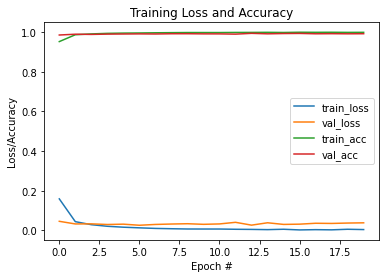

In [12]:
# plot the training loss and accuracy
#plt.style.use("ggplot")
%matplotlib inline
plt.figure()
plt.plot(np.arange(0, 20), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 20), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()